# **Product Vision Search:** Build a Product recognition engine in one hour
This example is using a Kaggle dataset for product recognition. The goal is to extract a csv for bulk import in Product Vision Search  
**Useful links:**  
https://github.com/zinjiggle/google-product-search-simple-ui  
https://github.com/GoogleCloudPlatform/python-docs-samples/tree/master/vision/cloud-client/product_search

## 1. Data preparation (using Bigquery)
The first step is to prepare a table in the proper format.
* **image-uri**: The Google Cloud Storage URI of the reference image.
* **image-id**: Optional. A unique value if you supply it. Otherwise, the system will assign a unique value.
* **product-set-id**: A unique identifier for the product set to import the images into.
* **product-id**: A user-defined ID for the product identified by the reference image. A product-id can be associated with multiple reference images. Note: A single product may also belong to several product sets. If a product-id already exists on bulk import then product-category, product-display, and labels are ignored for that line entry.
* **product-category**: Allowed values are homegoods-v2, apparel-v2, toys-v2, packagedgoods-v1, and general-v1 *; the category for the product identified by the reference image. Inferred by the system if not specified in the create request. Allowed values are also listed in the productCategory reference documentation. Legacy productCategory codes: Legacy categories (homegoods, apparel, and toys) are still supported, but the updated -v2 categories should be used for new products.
* **product-display-name**: Optional. If you don't provide a name for the product displayName will be set to " ". You can update this value later.
* **labels**: Optional. A string (with quotation marks) of key-value pairs that describe the products in the reference image. For example:"color=black,style=formal"
* **bounding-poly**: Optional. Specifies the area of interest in the reference image. If a bounding box is not specified: Bounding boxes for the image are inferred by the Vision API; multiple regions in a single image may be indexed if multiple products are detected by the API. The line must end with a comma. See the example below for a product without a bounding poly specified.If you include a bounding box, the boundingPoly column should contain an even number of comma-separated numbers, with the format p1_x,p1_y,p2_x,p2_y,...,pn_x,pn_y. An example line looks like this: 0.1,0.1,0.9,0.1,0.9,0.9,0.1,0.9.

In [ ]:
pip install google-cloud-vision

In [ ]:
%%bigquery
SELECT category_level1, count(*) num_products  
FROM 
    `pod-fr-retail.kaggle.train_images` a 
JOIN `pod-fr-retail.kaggle.category_names`  b 
ON CAST(b.category_id AS STRING) =(REGEXP_EXTRACT(a.path_to_images,r'gs://pod-fr-retail-kaggle/train-images/[0-9]*/([^-]*)'))
GROUP BY 1 ORDER BY 2 desc

In [ ]:
%%bigquery
SELECT category_level2
from `pod-fr-retail.kaggle.category_names` 
WHERE category_level1 like 'CHAUSSURES%'
GROUP BY 1

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `pod-fr-retail.kaggle.products_vision_search` AS
SELECT 
    a.* EXCEPT (category_id)
    ,CONCAT(replace(lower(CONCAT('','cl1=',b.category_level1,',cl2=',b.category_level2,',cl3=',b.category_level3,' ')),' ','')) labels
    ,null as poly
FROM (
    SELECT 
        path_to_images image_uri
        ,(REGEXP_EXTRACT(path_to_images,r'gs://pod-fr-retail-kaggle/train-images/[0-9]*/([0-9]*-[0-9]*-[0-9]*)')) AS image_id
        ,'kaggle_shoes' as product_set_id
        ,(REGEXP_EXTRACT(path_to_images,r'gs://pod-fr-retail-kaggle/train-images/[0-9]*/[0-9]*-([0-9]*)')) AS product_id
        ,(REGEXP_EXTRACT(path_to_images,r'gs://pod-fr-retail-kaggle/train-images/[0-9]*/([^-]*)')) AS category_id
        ,'apparel-v2' product_category
        ,(REGEXP_EXTRACT(path_to_images,r'gs://pod-fr-retail-kaggle/train-images/[0-9]*/[0-9]*-([0-9]*)')) AS product_display_name
    FROM `pod-fr-retail.kaggle.train_images`
  ) a 
JOIN (SELECT * FROM `pod-fr-retail.kaggle.category_names` 
      WHERE 
      #category_level1='HYGIENE - BEAUTE - PARFUM'
      #category_level1='CHAUSSURES - ACCESSOIRES'
      category_level1 like 'CHAUSSURES%'
  ) b 
ON CAST(b.category_id AS STRING) =a.category_id
#WHERE rand()<0.10;

# 2. Data extraction (export CSV for bulk import)
Extract from BigQuery to Google Cloud Storage and split file in multiple files (20k lines max per file)

In [61]:
productsTable='pod-fr-retail:kaggle.products_vision_search'
destinationCSV="gs://pod-fr-retail-kaggle/products_vision_search.csv"
destinationSplittedCSV="gs://pod-fr-retail-kaggle/products_vision_search/split/part"

In [ ]:
%%bash -s $productsTable $destinationCSV
bq extract --print_header=false $1 $2

In [62]:
%%bash -s $destinationCSV
gsutil cat  $1 | sed -n '1,1p'  

gs://pod-fr-retail-kaggle/train-images/4000000/1000010547-13111765-1.jpg,1000010547-13111765-1,kaggle_shoes,13111765,apparel-v2,13111765,"cl1=chaussures-accessoires,cl2=bottes-bottines,cl3=botte",


In [ ]:
%%bash -s $destinationCSV $destinationSplittedCSV
TOTAL_ROWS=$(gsutil cat $1 | wc -l);
MAX_ROWS=20000;
j=1
k=1
for (( i=1; i<=$TOTAL_ROWS; i++ ))
do 
    if [ $(($i%MAX_ROWS)) == 0 ]; then 
        gsutil -q cat $1 | sed -n "$j"','"$i"'p'  |  gsutil -q cp - $2-$k.csv
        echo "File $2-$k.csv created" 
        j=$((i+1))
        k=$((k+1))
    fi
done
if [ $(($i < TOTAL_ROWS)) ]; then 
        gsutil -q cat $1 | sed -n "$j"','"$TOTAL_ROWS"'p'  |  gsutil -q cp - $2-$k.csv
fi

# 3. Product set creation
Bulk import every files to Vision Product Search (to a specific product set id specified in the file itself)

## 3.1 List all files

In [4]:
from google.cloud import storage
client = storage.Client()
bucket_name = "pod-fr-retail-kaggle"
bucket = client.get_bucket(bucket_name)
blobs = client.list_blobs(bucket_name, prefix='products_vision_search/split/')
gcs_uris=[]
for item in blobs:
    gcs_uris.append(item.name)
    print('\t',item.name)
    
print("gs://pod-fr-retail-kaggle/","products_vision_search/split/",gcs_uris[0])

	 products_vision_search/split/part-1.csv
	 products_vision_search/split/part-10.csv
	 products_vision_search/split/part-11.csv
	 products_vision_search/split/part-12.csv
	 products_vision_search/split/part-13.csv
	 products_vision_search/split/part-14.csv
	 products_vision_search/split/part-15.csv
	 products_vision_search/split/part-16.csv
	 products_vision_search/split/part-17.csv
	 products_vision_search/split/part-18.csv
	 products_vision_search/split/part-19.csv
	 products_vision_search/split/part-2.csv
	 products_vision_search/split/part-3.csv
	 products_vision_search/split/part-4.csv
	 products_vision_search/split/part-5.csv
	 products_vision_search/split/part-6.csv
	 products_vision_search/split/part-7.csv
	 products_vision_search/split/part-8.csv
	 products_vision_search/split/part-9.csv
gs://pod-fr-retail-kaggle/ products_vision_search/split/ products_vision_search/split/part-1.csv


In [5]:
project_id='pod-fr-retail'
location='europe-west1'
product_set='kaggle_shoes'
gcs_bucket="gs://pod-fr-retail-kaggle/"
gcs_uri=gcs_bucket+gcs_uris[0]
print(gcs_uri)

gs://pod-fr-retail-kaggle/products_vision_search/split/part-1.csv


## 3.2 Import files and store responses (operation) 

In [37]:
from google.cloud import vision_v1

In [38]:
responses=[]
client = vision_v1.ProductSearchClient()
parent = client.location_path(project_id, location)

def callback(operation_future):
        # Handle result.
        result = operation_future.result()
        
for gcs_uri in gcs_uris:
    gcs_source = vision_v1.types.ImportProductSetsGcsSource(csv_file_uri = gcs_bucket+gcs_uri)
    input_config = vision_v1.types.ImportProductSetsInputConfig(gcs_source=gcs_source)
    response = client.import_product_sets(parent, input_config)
    response.add_done_callback(callback)
    responses.append(response)
# Handle metadata.
#metadata = response.metadata()

In [ ]:
for response in responses:
    print(response.operation.name, ':')
    print(response.metadata)
    print('--------------------')

## 3.3 Check index time of product sets 

In [ ]:
import time
from google.cloud import vision_v1
client = vision_v1.ProductSearchClient()
parent = client.location_path(project_id, location)
name = client.product_set_path(project_id, location, product_set)
for element in client.list_product_sets(parent):
    print(element)
    print('Last index:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(element.index_time.seconds)))
    print('------')
    pass
#print(client.list_products_in_product_set(name))


In [159]:
from google.cloud import vision
from google.cloud import storage
from IPython.display import Image, display

def get_image(uri):
    client_storage = storage.Client(credentials=credentials) # Implicit environment set up
    bucket = uri.split("/")[2]
    object_name = "/".join(uri.split("/")[3:])
    # with explicit set up:
    # client = storage.Client.from_service_account_json('key-file-location')
    bucket = client_storage.get_bucket(bucket)
    blob = bucket.get_blob(object_name)
    return(Image(blob.download_as_bytes()))
    
def get_similar_products_file(
        project_id,
        location,
        product_set_id,
        product_category,
        file_path,
        filter,
        max_results
):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
                Example for filter: (color = red OR color = blue) AND style = kids
                It will search on all products with the following labels:
                color:red AND style:kids
                color:blue AND style:kids
        max_results: The maximum number of results (matches) to return. If omitted, all results are returned.
    """
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.types.image_annotator_pb2.Image(content=content)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.types.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.types.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image,
        image_context=image_context,
        max_results=max_results
    )
    
    index_time = response.product_search_results.index_time
    print('Product set index time: ')
    print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    i=0
    for result in results:
        print('--------------------Result ', i)
        image = product_search_client.get_reference_image(name=result.image)
        display(get_image(image.uri))
        product = result.product
        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))
        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: {}\n'.format(product.product_labels))
        print('--------------------------')
        i=i+1

Product set index time: 
seconds: 1665843567
nanos: 837234043

Search results:
--------------------Result  0


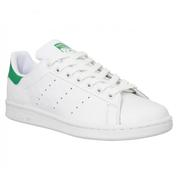

Score(Confidence): 0.7613340616226196
Image name: projects/pod-fr-retail/locations/europe-west1/products/12639984/referenceImages/1000010538-12639984-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/12639984
Product display name: 12639984
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------------
--------------------Result  1


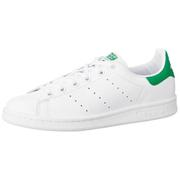

Score(Confidence): 0.7419224381446838
Image name: projects/pod-fr-retail/locations/europe-west1/products/20999212/referenceImages/1000010538-20999212-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/20999212
Product display name: 20999212
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------------
--------------------Result  2


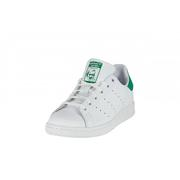

Score(Confidence): 0.7251256108283997
Image name: projects/pod-fr-retail/locations/europe-west1/products/3678282/referenceImages/1000010538-3678282-1
Product name: projects/pod-fr-retail/locations/europe-west1/products/3678282
Product display name: 3678282
Product description: 

Product labels: [key: "cl1"
value: "chaussures-accessoires"
, key: "cl2"
value: "basket-sportswear"
, key: "cl3"
value: "basket"
]

--------------------------


In [160]:
get_similar_products_file(
        project_id,
        location,
        product_set,
        product_category="apparel-v2",
        file_path="adidas.jpeg",
        filter="",
        max_results=3
)

In [129]:
sample_get_product(name='projects/pod-fr-retail/locations/europe-west1/products/12639984')

name: "projects/pod-fr-retail/locations/europe-west1/products/12639984"
display_name: "12639984"
product_category: "apparel-v2"
product_labels {
  key: "cl1"
  value: "chaussures-accessoires"
}
product_labels {
  key: "cl2"
  value: "basket-sportswear"
}
product_labels {
  key: "cl3"
  value: "basket"
}



## 3.4 Delete product sets (disabled / do not remove products) 